# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle
from sklearn.cross_validation import train_test_split
RANDOM_STATE = 42


# TODO: Fill this in based on where you saved the training and testing data
training_file = "train.p"
testing_file = "test.p"


with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_train, X_validation, y_train, y_validation = train_test_split(X_train,
                                                                y_train, 
                                                                test_size = 0.20,
                                                                random_state = RANDOM_STATE)
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

C:\Users\Ralph\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
import numpy as np

n_train = X_train.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]
n_classes = len(set(y_train))

print("Image Shape:       {}".format(X_train[0].shape))
print("Training Set:      {} samples".format(len(X_train)))
print("Validation Set:    {} samples".format(len(X_validation)))
print("Test Set:          {} samples".format(len(X_test)))
print("Number of classes: {}".format(n_classes))

Image Shape:       (32, 32, 3)
Training Set:      31367 samples
Validation Set:    7842 samples
Test Set:          12630 samples
Number of classes: 43


In [4]:
#Create pandas series mapping the numerical traffic sign IDs to the corresponding sign names
import pandas
sign_names = pandas.read_csv('signnames.csv',
                             sep = None,
                             skipinitialspace = True,
                             usecols = [1],
                             squeeze = True,
                             engine = 'python')

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

The most frequent traffic sign in the training set is ' Speed limit (50km/h) ', with  1800   occurences.
The least frequent traffic sign in the training set is ' Go straight or left ', with  163    occurences.
The ratio most_frequent/least_frequent is  11.042944785276074


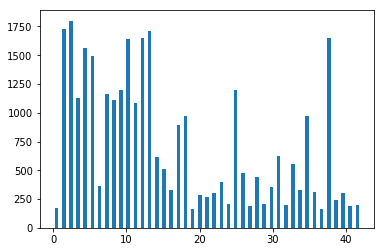

In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
from collections import Counter
# Visualizations will be shown in the notebook.
%matplotlib inline
plt.hist(y_train,bins=n_classes, rwidth=0.5)
count = Counter(y_train)
most_frequent=count.most_common()[0]
least_frequent=count.most_common()[-1]
print("The most frequent traffic sign in the training set is '", 
      sign_names[most_frequent[0]],"', with ", most_frequent[1],"  occurences.")
print("The least frequent traffic sign in the training set is '", 
      sign_names[least_frequent[0]],"', with ",least_frequent[1],"   occurences.")
print("The ratio most_frequent/least_frequent is ", most_frequent[1]/least_frequent[1])

The histogramm reveals that the training set is extremely unbalanced, with the most frequent sign occuring more than 10 times more often than the least frequent. Since the traffic signs were recorded in real life traffic situations, the distribution of the training samples may represent the real distribution of signs in US traffic. A classifier trained on such an unbalanced dataset will however not be able to learn the less common signs well enough, which is potentially dangerous, since the frequency of occurence is not correlated with the relevance of a traffic sign. 

Common mitigation strategies for unbalanced datasets are the augmentation of underrepresented classes by artificially created samples, or the subsampling of a balanced training set before each training step. The implementation of such a strategy is deferred to a later iteration of this notebook. 

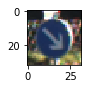

Keep right


In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
plt.show()
print(sign_names[y_train[index]])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

The color channels are normalized by including *tf.nn.l2_normalize(x, 2, epsilon=1e-12, name=None)* in the tensorflow pipeline (see below). Normalization prevents the neurons from saturation and enhances generalization.  Grayscale conversion is not included in the preprocessing pipeline, since the color channels may encode relevant information for traffic sign discrimination (e.g. red vs green).

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?

**Answer:**
The traffic sign dataset comes pre-packacked in a training and testing set. The initial training set is further split into an actual training set of 80% and a validation set of 20% of the original data. The validation set can be used to validate several training setups and hyperparameter combinations whereas the test set is retained for measuring the performance of the trained network. 

In [7]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6),
                                              mean = mu,
                                              stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x,
                           conv1_W,
                           strides=[1, 1, 1, 1],
                           padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='VALID')

    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16),
                                              mean = mu, 
                                              stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1,
                           conv2_W,
                           strides=[1, 1, 1, 1],
                           padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='VALID')

    fc0   = flatten(conv2)
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120),
                                            mean = mu,
                                            stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84),
                                             mean = mu,
                                             stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2,
                           keep_prob)

    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes),
                                             mean = mu,
                                             stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
The model architecture is based on the classical LeNet architecture, as decribed in http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf. A dropout layer was added after the second fully connected layer, to improve generalization. 
The final architecture can be illustrated as follows:  

<img src="images/lenet5.png">

In [8]:
KEEP_PROB = 0.8
NO_DROPOUT = 1.

EPOCHS = 15
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
x = tf.nn.l2_normalize(x, 2, epsilon=1e-12, name=None)
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

rate = 0.001

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x,
                                                           y: batch_y,
                                                           keep_prob: NO_DROPOUT})
        
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, 
                                                    y: batch_y,
                                                    keep_prob: KEEP_PROB})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess,"lenet/")
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.644

EPOCH 2 ...
Validation Accuracy = 0.825

EPOCH 3 ...
Validation Accuracy = 0.883

EPOCH 4 ...
Validation Accuracy = 0.914

EPOCH 5 ...
Validation Accuracy = 0.935

EPOCH 6 ...
Validation Accuracy = 0.942

EPOCH 7 ...
Validation Accuracy = 0.955

EPOCH 8 ...
Validation Accuracy = 0.955

EPOCH 9 ...
Validation Accuracy = 0.960

EPOCH 10 ...
Validation Accuracy = 0.966

EPOCH 11 ...
Validation Accuracy = 0.966

EPOCH 12 ...
Validation Accuracy = 0.970

EPOCH 13 ...
Validation Accuracy = 0.965

EPOCH 14 ...
Validation Accuracy = 0.961

EPOCH 15 ...
Validation Accuracy = 0.969

Model saved


In [9]:
with tf.Session() as sess:
    saver.restore(sess, 'lenet/')
    print("The accuracy on the test set is ",
          sess.run(accuracy_operation, feed_dict={x: X_test,
                                                  y: y_test,
                                                  keep_prob: NO_DROPOUT}))

The accuracy on the test set is  0.896358


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
It is highly unlikely that a deep learning architecture built from scratch is able to outperform sophisticated current deep learning architectures that regularly achieve accuracy results of 0.95(+) on image classification tasks. A more promising approach is to try and reproduce the results of existing architectures and then build on it by modifying carefully selected hyperparameters, or improving the preprocessing pipeline. With its straightforward architecture, a low training time and a proven track reckord on various image classification tasks, LeNet is a good starting point.

The original LeNet5 architecture was augmented by a dropout layer, to reduce overfitting and increase generalization. A low dropout rate of 0.2 proved to be sufficient, since the accuracy results on the test set are already relatively closed to the validation accuracy without dropping out. The network was trained for 15 epochs, generating an accuracy of 0.97 on the validation set. Training for more epochs may lead to overfitting the network to the dataset.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

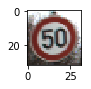

Speed limit (50km/h)


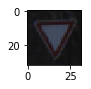

Yield


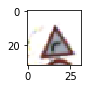

Dangerous curve to the right


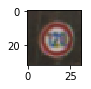

Speed limit (120km/h)


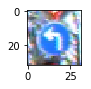

Turn left ahead


In [11]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#reading in sign images
import os
import numpy
numpy.random.seed(seed=44)
test_sample_idx = np.random.choice(len(X_test), 5)

for i in test_sample_idx:
    plt.figure(figsize=(1,1))
    plt.imshow(X_test[i].squeeze())  
    plt.show()
    print(sign_names[y_test[i]])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
The five candidates were randomly drawn from the traffic sign test set. Although these images belong to the same population as the training images, some specific features may represent a challenge for the trained network. The first sign is clearly visible, but it is very similar to other speed limit signs and may be confused with *speed limit 60 km/h*, e.g . The second sign is more distinctive, but very blurry - as well as the fourth sign, which may therefore be confused with another 3-figure speed limit sign. the slightly distorted angle of the third sign could also pose a problem.

In [12]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
output=[]
with tf.Session() as sess:
    saver.restore(sess, 'lenet/')
    softmax = tf.nn.softmax(logits)
    output = sess.run(softmax, feed_dict={x: X_test[test_sample_idx],
                                          keep_prob: NO_DROPOUT})

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The softmax distribution below reveals, that the classifier correctly classifies the one sign it knows with a certainty of 100%. It is however also extremely certain in the 4 wrongly classified signs, which intuitively is not desirable. This is an indication of overfitting and low generalization, which could be mitigated by balancing the training data set and by adding perturbed images created from the original samples. 

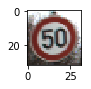

correct sign name: Speed limit (50km/h)
predicted sign names:
Speed limit (50km/h): 0.918473124504
Speed limit (80km/h): 0.081051528454
Speed limit (30km/h): 0.000475256995
Speed limit (60km/h): 0.000000035286
Speed limit (20km/h): 0.000000000230



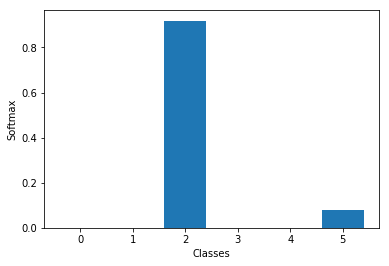

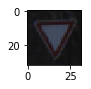

correct sign name: Yield
predicted sign names:
Yield: 1.000000000000
No passing for vehicles over 3.5 metric tons: 0.000000000000
No vehicles: 0.000000000000
Ahead only: 0.000000000000
Road work: 0.000000000000



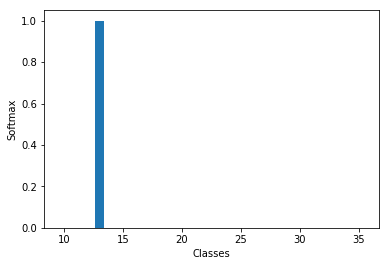

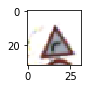

correct sign name: Dangerous curve to the right
predicted sign names:
Beware of ice/snow: 1.000000000000
Right-of-way at the next intersection: 0.000000000000
Children crossing: 0.000000000000
Dangerous curve to the right: 0.000000000000
Pedestrians: 0.000000000000



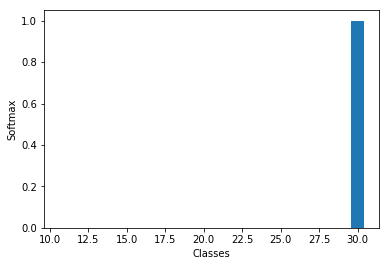

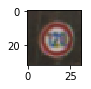

correct sign name: Speed limit (120km/h)
predicted sign names:
Speed limit (120km/h): 0.999777138233
Speed limit (100km/h): 0.000222226488
Speed limit (70km/h): 0.000000671629
Speed limit (50km/h): 0.000000000246
No vehicles: 0.000000000001



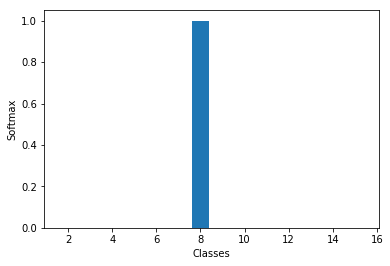

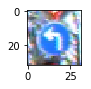

correct sign name: Turn left ahead
predicted sign names:
Turn left ahead: 1.000000000000
Keep right: 0.000000000000
Dangerous curve to the right: 0.000000000000
Yield: 0.000000000000
Turn right ahead: 0.000000000000



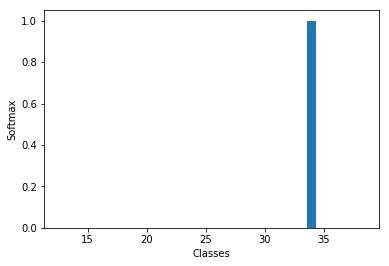

In [39]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
for i in range(output.shape[0]):
    inds = np.argsort(output)[i, :]
    #top_candidates = sign_names[inds[-5:]]
    top_candidates = inds[-5:]
    softmaxes = output[i, inds[-5:]]
    plt.figure(figsize=(1,1))
    plt.imshow(X_test[test_sample_idx[i]].squeeze())  
    plt.show()
    plt.bar(top_candidates, softmaxes)
    plt.xlabel('Classes')
    plt.ylabel('Softmax')
    print("correct sign name: "+sign_names[y_test[test_sample_idx[i]]])
    print("predicted sign names:")
    for j in range(5):
        print("%s: %.12f" % (sign_names[inds[-1 - j]], output[i, inds[-1 - j]]))
    print() 


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

**Answer:**
The evaluation of the softmax probabilities above reveals, that the network generally seems to be very confident in its predictions. 

The label distribution for the two speed limit sign shows that the network is able to detect similarities, but also to discriminate correctly based on small details. The good results for the speed limit signs could however be partly attributed to their overrepresentation in the training set. 

Contrary to the initial assumption, the network doesn't seem to have any problem classifying the blurred *yield* sign. But it completely fails to detect the slightly distorted *Dangerous curve to the right* and is much too confident in its wrong classification. These types of errors could be mitigated by augmenting the initial dataset with rotated, shifted, flipped, etc. versions of the original images. 

In [40]:
with tf.Session() as sess:
    print(sess.run(tf.nn.top_k(output, k=5)))

TopKV2(values=array([[  9.18473125e-01,   8.10515285e-02,   4.75256995e-04,
          3.52855061e-08,   2.29879060e-10],
       [  1.00000000e+00,   1.20875262e-18,   3.73025524e-19,
          1.39764301e-19,   1.16547357e-19],
       [  1.00000000e+00,   1.12708652e-16,   6.59503559e-17,
          4.18573176e-17,   3.14395427e-22],
       [  9.99777138e-01,   2.22226488e-04,   6.71628925e-07,
          2.45566678e-10,   1.44877697e-12],
       [  1.00000000e+00,   1.33225418e-16,   4.17757748e-26,
          4.39530691e-30,   1.00316349e-30]], dtype=float32), indices=array([[ 2,  5,  1,  3,  0],
       [13, 10, 15, 35, 25],
       [30, 11, 28, 20, 27],
       [ 8,  7,  4,  2, 15],
       [34, 38, 20, 13, 33]]))


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.